Total images in dataframe: 300
IMAGES_FOLDER found: /kaggle/input/glaucoma-datasets/G1020/Images
Total images after augmentation: 1200
Total labels: 1200
Total OD masks: 1200
Total OC masks: 1200


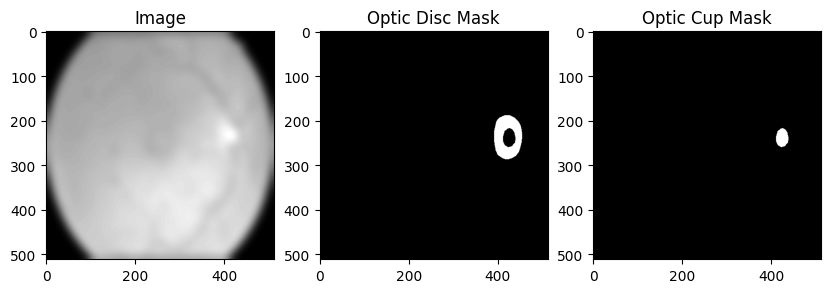

Epoch 1/70
420/420 ━━━━━━━━━━━━━━━━━━━━ 132s 253ms/step - loss: 0.6493 - oc_output_accuracy: 0.9965 - oc_output_loss: 0.3056 - od_output_accuracy: 0.9826 - od_output_loss: 0.3437 - val_loss: 0.1243 - val_oc_output_accuracy: 0.9960 - val_oc_output_loss: 0.0306 - val_od_output_accuracy: 0.9830 - val_od_output_loss: 0.0937
Epoch 2/70
420/420 ━━━━━━━━━━━━━━━━━━━━ 94s 224ms/step - loss: 0.1162 - oc_output_accuracy: 0.9966 - oc_output_loss: 0.0258 - od_output_accuracy: 0.9834 - od_output_loss: 0.0903 - val_loss: 0.1127 - val_oc_output_accuracy: 0.9960 - val_oc_output_loss: 0.0267 - val_od_output_accuracy: 0.9830 - val_od_output_loss: 0.0860
Epoch 3/70
420/420 ━━━━━━━━━━━━━━━━━━━━ 94s 225ms/step - loss: 0.1065 - oc_output_accuracy: 0.9965 - oc_output_loss: 0.0227 - od_output_accuracy: 0.9831 - od_output_loss: 0.0838 - val_loss: 0.0998 - val_oc_output_accuracy: 0.9960 - val_oc_output_loss: 0.0226 - val_od_output_accuracy: 0.9830 - val_od_output_loss: 0.0772
Epoch 4/70
420/420 ━━━━━━━━━━━━━━━━━

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.image import resize
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, LSTM
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, ResNet152, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from skimage import morphology
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

IMAGES_FOLDER = "/kaggle/input/glaucoma-datasets/G1020/Images"
df = pd.read_csv("/kaggle/input/glaucoma-datasets/G1020/G1020.csv")
MASK_FOLDER = "/kaggle/input/glaucoma-datasets/G1020/Masks"

df = df.sample(n=300, random_state=42)
df = df.head(300)

def load_data(df, image_size=(512, 512)):
    images, labels, od_masks, oc_masks = [], [], [], []
    
    print(f"Total images in dataframe: {len(df)}")

    if not os.path.exists(IMAGES_FOLDER):
        print(f"Error: IMAGES_FOLDER not found: {IMAGES_FOLDER}")
    else:
        print(f"IMAGES_FOLDER found: {IMAGES_FOLDER}")

    missing_images = [img for img in df['imageID'] if not os.path.exists(os.path.join(IMAGES_FOLDER, img))]
    if missing_images:
        print(f"Missing images: {len(missing_images)} images not found.")

    def rotate_image(image, angle):
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, rot_matrix, (w, h))
        return cv2.resize(rotated, (512, 512)).reshape(512, 512, 1)

    for index, row in df.iterrows():
        img_name = row['imageID']
        label = row['binaryLabels']
        img_path = os.path.join(IMAGES_FOLDER, img_name)

        base_name = os.path.splitext(img_name)[0]  
        mask_name = f"{base_name}.png" 
        mask_path = os.path.join(MASK_FOLDER, mask_name)

        if os.path.exists(img_path) and os.path.exists(mask_path):
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, image_size)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.GaussianBlur(image, (65, 65), 0)
            image = image.reshape(image_size[0], image_size[1], 1)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, image_size)

            optic_disc = np.where(mask == 1, 255, 0).astype(np.uint8).reshape(image_size[0], image_size[1], 1)
            optic_cup = np.where(mask == 2, 255, 0).astype(np.uint8).reshape(image_size[0], image_size[1], 1)

            images.append(image)
            labels.append(label)
            od_masks.append(optic_disc)
            oc_masks.append(optic_cup)

            for angle in [45, 90, 170]:
                rotated_img = rotate_image(image, angle)
                rotated_od = rotate_image(optic_disc, angle)
                rotated_oc = rotate_image(optic_cup, angle)

                images.append(rotated_img)
                labels.append(label)
                od_masks.append(rotated_od)
                oc_masks.append(rotated_oc)

        else:
            print(f"Image not found: {img_path}")

    images = np.array(images) / 255.0
    labels = np.array(labels)
    od_masks = np.array(od_masks) / 255.0
    oc_masks = np.array(oc_masks) / 255.0

    print(f"Total images after augmentation: {len(images)}")
    print(f"Total labels: {len(labels)}")
    print(f"Total OD masks: {len(od_masks)}")
    print(f"Total OC masks: {len(oc_masks)}")

    idx = 0  
    plt.figure(figsize=(10,5))
    plt.subplot(131)
    plt.imshow(images[idx].squeeze(), cmap='gray')
    plt.title('Image')
    plt.subplot(132)
    plt.imshow(od_masks[idx].squeeze(), cmap='gray')
    plt.title('Optic Disc Mask')
    plt.subplot(133)
    plt.imshow(oc_masks[idx].squeeze(), cmap='gray')
    plt.title('Optic Cup Mask')
    plt.show()

    return images, labels, od_masks, oc_masks  
    
images, labels, od_masks, oc_masks = load_data(df)

X_train, X_temp, y_train, y_temp, od_train, od_temp, oc_train, oc_temp = train_test_split(
    images, labels, od_masks, oc_masks, test_size=0.3, stratify=pd.Series(labels), random_state=42)

X_val, X_test, y_val, y_test, od_val, od_test, oc_val, oc_test = train_test_split(
    X_temp, y_temp, od_temp, oc_temp, test_size=0.5, stratify=pd.Series(y_temp), random_state=42)


def build_unet():
    inputs = layers.Input((512, 512, 1))

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = Dropout(0.5)(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Dropout(0.5)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    od_outputs = Conv2D(1, (1, 1), activation='sigmoid', name='od_output')(c9)
    oc_outputs = Conv2D(1, (1, 1), activation='sigmoid', name='oc_output')(c9)

    model = Model(inputs=inputs, outputs=[od_outputs, oc_outputs])
    return model

unet = build_unet()
unet.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0004, momentum=0.95),
    loss='binary_crossentropy',
    metrics=[['accuracy'],['accuracy']]
)

unet.fit(X_train, [od_train, oc_train], epochs=70, batch_size=2, 
         validation_data=(X_val, [od_val, oc_val]))

od_pred, oc_pred = unet.predict(X_test)

print("Prediction complete!")


In [2]:
def calculate_cdr(disc_mask, cup_mask):
    disc_area = np.sum(disc_mask)
    cup_area = np.sum(cup_mask)
    disc_mask = (disc_mask > 0).astype(np.uint8)
    cup_mask = (cup_mask > 0).astype(np.uint8)


    return round((2 * cup_area) / disc_area, 4) if disc_area != 0 else 0

def extract_isnt_quadrants(disc_mask, cup_mask):
    disc_mask = disc_mask.squeeze()
    cup_mask = cup_mask.squeeze()

    disc_mask_rotated = np.rot90(disc_mask)
    cup_mask_rotated = np.rot90(cup_mask)

    nrr_mask = cv2.bitwise_xor(disc_mask_rotated, cup_mask_rotated)

    height, width = disc_mask.shape
    I = np.sum(nrr_mask[height//2:, :])
    S = np.sum(nrr_mask[:height//2, :])
    N = np.sum(nrr_mask[:, :width//2])
    T = np.sum(nrr_mask[:, width//2:])

    return round((1 + (I + S)) / (1 + (N + T)), 4) if (N + T) != 0 else 0

def extract_blood_vessels(fundus_image):
    if len(fundus_image.shape) == 2 or fundus_image.shape[2] == 1:
        green_channel = fundus_image[:, :, 0].astype(np.uint8)
    else:
        green_channel = fundus_image[:, :, 1].astype(np.uint8) 
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(6,6))
    enhanced = clahe.apply(green_channel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    bottom_hat = cv2.morphologyEx(enhanced, cv2.MORPH_BLACKHAT, kernel)

    threshold_value = max(10, 3.15 * np.std(bottom_hat))
    _, vessel_mask = cv2.threshold(bottom_hat, threshold_value, 255, cv2.THRESH_BINARY)

    height, width = vessel_mask.shape
    I = np.sum(vessel_mask[height//2:, :])
    S = np.sum(vessel_mask[:height//2, :])
    N = np.sum(vessel_mask[:, :width//2])
    T = np.sum(vessel_mask[:, width//2:])

    return round((1 + (I + S)) / (1 + (N + T)), 4) if (N + T) != 0 else 0

cdr_train = np.array([calculate_cdr(od, oc) for od, oc in zip(od_train, oc_train)])
isnt_train = np.array([extract_isnt_quadrants(od, oc) for od, oc in zip(od_train, oc_train)])
bvr_train = np.array([extract_blood_vessels(img) for img in X_train])

X_train_combined = np.hstack((cdr_train.reshape(-1,1), isnt_train.reshape(-1,1), bvr_train.reshape(-1,1)))

cdr_test = np.array([calculate_cdr(od, oc) for od, oc in zip(od_test, oc_test)])
isnt_test = np.array([extract_isnt_quadrants(od, oc) for od, oc in zip(od_test, oc_test)])
bvr_test = np.array([extract_blood_vessels(img) for img in X_test])

X_test_combined = np.hstack((cdr_test.reshape(-1,1), isnt_test.reshape(-1,1), bvr_test.reshape(-1,1)))


print(f"X_train_combined shape: {X_train_combined.shape}, y_train shape: {y_train.shape}")
print(f"X_test_combined shape: {X_test_combined.shape}, y_test shape: {y_test.shape}")

# to avoid bias 
smote = SMOTE(random_state=42)
X_train_combined, y_train = smote.fit_resample(X_train_combined, y_train)

# try code with Standard scalar for SVM model to balance feature extraction
scaler = MinMaxScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_test_combined = scaler.transform(X_test_combined)

# captures non-linear patterns
poly = PolynomialFeatures(degree=2, interaction_only=True) 
X_train_poly = poly.fit_transform(X_train_combined)
X_test_poly = poly.transform(X_test_combined)

svm_params = {'C': [1, 10, 100], 'gamma': [0.01, 1, 10], 'kernel': ['rbf']}
svm_grid = GridSearchCV(SVC(probability=True), svm_params, cv=5)
svm_grid.fit(X_train_poly, y_train)
print(f"Best SVM parameters: {svm_grid.best_params_}")
svm_predictions = svm_grid.best_estimator_.predict(X_test_poly)

knn_params = {'n_neighbors': [5, 7, 9, 11], 'weights': ['distance'], 'metric': ['manhattan']}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5)
knn_grid.fit(X_train_combined, y_train)
print(f"Best KNN parameters: {knn_grid.best_params_}")
knn_predictions = knn_grid.best_estimator_.predict(X_test_combined)

class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))
print("Computed Class Weights:", class_weights)

lr_schedule = ExponentialDecay(initial_learning_rate=0.005, decay_steps=100, decay_rate=0.9)
mlp = Sequential([
    Dense(512, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train_combined.shape[1],)),
    BatchNormalization(), 
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])
mlp.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['accuracy'])
mlp.fit(X_train_combined, y_train, epochs=150, batch_size=32, class_weight=class_weights)
mlp_predictions = (mlp.predict(X_test_combined) > 0.5).astype(int)

adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=150, learning_rate=0.8, random_state = 10)
adaboost.fit(X_train_combined, y_train)
adaboost_predictions = adaboost.predict(X_test_combined)

svm_accuracy = accuracy_score(y_test, svm_predictions)
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
adaboost_accuracy = accuracy_score(y_test, adaboost_predictions)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print(f"SVM Accuracy: {svm_accuracy}")
print(f"MLP Accuracy: {mlp_accuracy}")
print(f"AdaBoost Accuracy: {adaboost_accuracy}")
print(f"KNN Accuracy: {knn_accuracy}")

print(classification_report(y_test, svm_predictions))
print(classification_report(y_test, mlp_predictions))
print(classification_report(y_test, adaboost_predictions))
print(classification_report(y_test, knn_predictions))

X_train_combined shape: (840, 3), y_train shape: (840,)
X_test_combined shape: (180, 3), y_test shape: (180,)
Best SVM parameters: {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
Best KNN parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Computed Class Weights: {0: 1.0, 1: 1.0}
Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.5136 - loss: 5.3830
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5643 - loss: 3.7057
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5374 - loss: 3.0139
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5256 - loss: 2.6044
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5276 - loss: 2.3061
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5801 - loss: 2.1058
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5207 - loss: 1.9165
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4792 - loss: 1.7732
Epoch 9/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5417 - loss: 1.6121
Epoch 10/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5685 - loss: 1.4769
Epoch 11/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5568 - loss: 1.3850
Epoch 12/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5178 - l

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


SVM Accuracy: 0.55
MLP Accuracy: 0.46111111111111114
AdaBoost Accuracy: 0.9333333333333333
KNN Accuracy: 0.9111111111111111
              precision    recall  f1-score   support

           0       0.74      0.53      0.62       124
           1       0.36      0.59      0.45        56

    accuracy                           0.55       180
   macro avg       0.55      0.56      0.53       180
weighted avg       0.62      0.55      0.57       180

              precision    recall  f1-score   support

           0       0.79      0.30      0.43       124
           1       0.35      0.82      0.49        56

    accuracy                           0.46       180
   macro avg       0.57      0.56      0.46       180
weighted avg       0.65      0.46      0.45       180

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       124
           1       0.92      0.86      0.89        56

    accuracy                           0.93       180
   m